# 0.0 General Section

## 0.1 Import Libraries

In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import warnings
import random
import pickle
import json
import requests

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings( 'ignore' )

In [6]:
y=[250, 100, 150, 500]
y_pred=[270, 70, 90, 510]

mean_absolute_percentage_error(y, y_pred)

0.2

## 0.2 Load Data

In [2]:
df_train_feat = pd.read_csv( '../data/train_feat.csv',  low_memory= False )

## 0.3 Change Types

In [3]:
df_train_feat =         df_train_feat.drop( columns=['Unnamed: 0'], axis=1 )
df_train_feat['date'] = pd.to_datetime( df_train_feat['date'] )

## 0.3 Functions

In [4]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =  []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=( k-1 )*6*7 )

        if verbose:
            print(f'\nValidation Block: { k }. Dates: { validation_start_date } - { validation_end_date }' )

                                                                            
        # filtering dataset
        training   = x_training[ x_training['date'] <= validation_start_date]
        validation = x_training[ (x_training['date'] > validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

        

    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV'  : np.round( np.mean( mae_list ),  2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
                        }, index=[0] )



def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.5 Split df_feat_train in two datasets: X_train( full ) and X_validation( last 36 weeks )

In [5]:
# calculate period - last 36  weeks
last_date  = df_train_feat[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=36*7 )

last_date_period = last_date

print(f'First date: {first_date}')
print(f'Last date: {last_date}')

# creating full datasets: X_train e X_validation
X_train      = df_train_feat.copy() 
X_validation = X_train[ X_train['date'] > first_date ]

# create x_train, y_train variables
x_train = X_train[ X_train['date'] <= first_date ]
y_train = x_train['sales']
x_train = x_train.drop( ['date', 'sales'], axis=1 )

# calculate period - first 6 weeks from validation dataset
first_date = X_validation[['store', 'date']].groupby( 'store' ).min().reset_index().loc[0, 'date']
last_date  = first_date + datetime.timedelta( days=6*7 )

print(f'\nFirst date Validation: {first_date}')
print(f'Last date Validation: {last_date}')

# create x_validation, y_validation variables
x_validation = X_validation[ X_validation['date'] < last_date ]
y_validation = x_validation['sales']
x_validation = x_validation.drop( ['date', 'sales'], axis=1 )

print(f'\n { last_date - first_date }' )


First date: 2014-10-10 00:00:00
Last date: 2015-06-19 00:00:00

First date Validation: 2014-10-11 00:00:00
Last date Validation: 2014-11-22 00:00:00

 42 days 00:00:00


# 1.0 Machine Learning Modelling

## 1.1 Average Model

In [6]:
# create aux_df with database test + response variable (sales)
aux1          = x_validation.copy()
aux1['sales'] = y_validation.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average Model', np.expm1( y_validation ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1160.150027,NaN,1568.681103


## 1.2 Linear Regression Model - Single Performance

In [7]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# create predictions
yhat_lr = lr_model.predict( x_validation )

# calculate performance
lr_model_result = ml_error( 'Linear Regression Model', np.expm1( y_validation ), np.expm1( yhat_lr) )
lr_model_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1856.500159,0.313258,2549.678627


### 1.2.1 Linear Regression Model - Cross Validation

In [8]:
lr_model_result_cv = cross_validation( X_train, 5, 'Linear Regression', lr_model, verbose=True )
lr_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00

Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.58 +/- 307.06,0.3 +/- 0.02,2965.86 +/- 481.91


## 1.3 Linear Regression Regularized Model (Lasso) - Single Performance

In [9]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# create predictions
yhat_lasso = lasso_model.predict( x_validation )

# calculate performance
lasso_model_result = ml_error( 'Linear Regression Regularized Model - Lasso', np.expm1( y_validation), np.expm1( yhat_lasso) )
lasso_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1839.005227,0.30353,2573.081173


### 1.3.1 Linear Regression Regularized Model (Lasso) - Cross Validation

In [10]:
lasso_model_result_cv = cross_validation( X_train, 5, 'Linear Regression Regularized - Lasso', lasso_model, verbose=True )
lasso_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00



Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized - Lasso,2131.36 +/- 359.07,0.29 +/- 0.01,3073.85 +/- 523.97


## 1.4 Random Forest Model - Single Performance

In [11]:
# define model
# rf_model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# create predictions
# yhat_rf = rf_model.predict( x_validation )

# calculate performance
# rf_model_result = ml_error( 'Random Forest Model', np.expm1( y_validation ), np.expm1( yhat_rf) )
# rf_model_result

### 1.4.1 Random Forest Model - Cross Validation

In [12]:
# rf_result_cv = cross_validation( X_train, 5, 'Random Forest Model', rf_model, verbose=True )
# rf_result_cv

## 1.5 XGBoost Model - Single Performance

In [13]:
# define model with default values of XGBoost's parameter
xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.3, 
                              max_depth=6,  
                              subsample=1,
                              colsample_bytree=1,
                              min_child_weight=1
                            ).fit( x_train, y_train )

# create predictions
yhat_xgb = xgb_model.predict( x_validation )

# calculate performance
xgb_model_result = ml_error( 'XGBoost Regressor', np.expm1( y_validation ), np.expm1( yhat_xgb) )
xgb_model_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,802.371419,0.125006,1114.776336


### 1.5.1 XGBoost Model - Cross Validation

In [14]:
xgb_model_result_cv = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=True )
xgb_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00

Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1055.69 +/- 168.96,0.15 +/- 0.02,1498.44 +/- 231.96


## 1.6 Models Performance

### 1.6.1 Single Performance

In [15]:
models_result = pd.concat( [avg_model_result, lr_model_result, lasso_model_result, xgb_model_result] )
models_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1160.150027,NaN,1568.681103
0,Linear Regression Model,1856.500159,0.313258,2549.678627
0,Linear Regression Regularized Model - Lasso,1839.005227,0.303530,2573.081173
0,XGBoost Regressor,802.371419,0.125006,1114.776336


### 1.6.2 Cross Validation Performance

In [16]:
models_result_cv = pd.concat( [lr_model_result_cv, lasso_model_result_cv, xgb_model_result_cv] )
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.58 +/- 307.06,0.3 +/- 0.02,2965.86 +/- 481.91
0,Linear Regression Regularized - Lasso,2131.36 +/- 359.07,0.29 +/- 0.01,3073.85 +/- 523.97
0,XGBoost Regressor,1055.69 +/- 168.96,0.15 +/- 0.02,1498.44 +/- 231.96


# 2.0 Hyperparameter Fine Tunning

## 2.1 Random Search

In [17]:
# create dict with names and values parameters
params = { 'n_estimators'     : [150, 170, 250, 300, 350],
           'eta'              : [0.1, 0.3],
           'max_depth'        : [3, 5, 9],
           'subsample'        : [0.1, 0.5, 0.7],
           'colsample_bytree' : [0.3, 0.5, 0.7],
           'min_child_weight' : [3, 8, 15]
          }

In [18]:
NUM_ITERATIONS = 10
xgb_model_result = pd.DataFrame()

for i in range( NUM_ITERATIONS ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
    print(f'Iteration n: { i+1 }. Parameters: { hp } ')

    # define model
    xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                ).fit( x_train, y_train )

    # create predictions
    yhat_xgb = xgb_model.predict( x_validation )

    # calculate performance
    result = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=False )
    xgb_model_result = pd.concat( [xgb_model_result, result] )

xgb_model_result

Iteration n: 1. Parameters: {'n_estimators': 150, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3} 


Iteration n: 2. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 3. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15} 
Iteration n: 4. Parameters: {'n_estimators': 250, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3} 
Iteration n: 5. Parameters: {'n_estimators': 150, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3} 
Iteration n: 6. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 8} 
Iteration n: 7. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3} 
Iteration n: 8. Parameters: {'n_estimators': 350, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_chi

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1810.98 +/- 211.36,0.25 +/- 0.01,2600.82 +/- 282.85
0,XGBoost Regressor,1163.68 +/- 164.91,0.16 +/- 0.01,1647.88 +/- 224.48
0,XGBoost Regressor,1393.06 +/- 183.51,0.2 +/- 0.02,1979.28 +/- 227.74
0,XGBoost Regressor,1444.35 +/- 159.12,0.2 +/- 0.01,2086.9 +/- 216.3
0,XGBoost Regressor,1613.5 +/- 203.7,0.22 +/- 0.02,2312.1 +/- 246.86
0,XGBoost Regressor,1647.64 +/- 186.77,0.23 +/- 0.01,2364.87 +/- 240.33
0,XGBoost Regressor,864.45 +/- 176.25,0.12 +/- 0.02,1249.84 +/- 261.82
0,XGBoost Regressor,917.89 +/- 149.05,0.13 +/- 0.01,1319.7 +/- 216.11
0,XGBoost Regressor,1807.75 +/- 205.26,0.25 +/- 0.01,2594.13 +/- 275.15
0,XGBoost Regressor,1077.37 +/- 197.14,0.15 +/- 0.02,1512.09 +/- 279.76


## 2.2 Final Search

### 2.2.1 Create test Dataset

In [19]:
# dataset with last 6 weeks - new data
X_test = pd.read_csv( '../data/test_feat.csv',  low_memory= False )
X_test = X_test.drop( columns=['Unnamed: 0'], axis=1 )

x_test = X_test.copy()
y_test = x_test['sales']

x_test = x_test.drop( columns=['date', 'sales'], axis=1 )

### 2.2.2 Execute Model with x_test

In [20]:
# selected parameters
# Iteration n: 7. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3} 

# define model
xgb_model_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=350,
                                    eta=0.1, 
                                    max_depth=9,  
                                    subsample=0.7,
                                    colsample_bytree=0.7,
                                    min_child_weight=3
                                  ).fit( x_train, y_train )

# create predictions
yhat_xgb_tuned = xgb_model_tuned.predict( x_test )

# calculate performance
xgb_model_tuned_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_model_tuned_result



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1026.266676,0.147114,1479.757677


In [21]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
mpe

0.030230088184131393

# 3.0 Translating Model´s Performance to Business

In [2]:
# copy full test dataset
#df3 = X_test.copy()

# return "sales" to original values
#df3['sales']             = np.expm1( df3['sales'] )
#df3['sales_predictions'] = np.expm1( yhat_xgb_tuned )
#df3['error']              = np.abs( df3['sales'] - df3['sales_predictions'])

#df3.head()

df_business = X_test[['date', 'sales']]
df_business.head()

NameError: name 'X_test' is not defined

In [65]:
df_mae = df3[ df3['store'] == 1][['store', 'date', 'sales', 'sales_predictions']]
df_mae['error']      = np.abs( df_mae['sales'] - df_mae['sales_predictions'])
df_mae['error_perc'] = np.abs( ( df_mae['sales'] - df_mae['sales_predictions'] ) / df_mae['sales'] )
#df_mae.head(36)

print(f'média:  { df_mae["error"].mean() } ')
print(f'soma:  { df_mae["error"].sum() } ')
print(f'count:  { df_mae["error"].count()} ')

print(f'worst scenario: { round( df_mae["sales_predictions"].sum() - df_mae["error"].sum(), 2 ) }' )
print(f'prediction: { round( df_mae["sales_predictions"].sum(), 2 ) }' )
print(f'best scenario: { round( df_mae["sales_predictions"].sum() + df_mae["error"].sum(), 2 ) }' )

média:  436.26134575737785 
soma:  15705.408447265603 
count:  36 
worst scenario: 136745.19
prediction: 152450.59375
best scenario: 168156.0


## 3.1 Business Performance

In [136]:
# sum of predictions
df_performance = df3[['store', 'sales', 'sales_predictions', 'error']].groupby( 'store' ).sum().reset_index()

# calculate MAE 
df_MAE = ( df3[['store', 'sales', 'sales_predictions']]
            .groupby( 'store' )
            .apply( lambda x: mean_absolute_error( x['sales'], x['sales_predictions'] ) )
            .reset_index()
            .rename( columns = { 0: 'MAE' } ) )

# merge dataframes SALES_PREDICTIONS AND MAE
df_performance = pd.merge( df_performance, df_MAE, how='inner', on='store' )

# calculate values
df_performance['worst_scenario'] = df_performance['sales_predictions'] - df_performance['error']
df_performance['best_scenario']  = df_performance['sales_predictions'] + df_performance['error']
df_performance['MAPE']           = np.round( np.abs( df_performance['error']  / df_performance['sales_predictions'] ) * 100, 2 )

df_performance['model_performance'] = df_performance['MAPE'].apply( lambda x : 'Excellent' if ( x <= 10.0 ) else 
                                                                               'Good'      if ( x > 10.0 ) & ( x <= 15.0 ) else
                                                                               'Regular'   if ( x > 15.0 ) & ( x <= 20.0 ) else 
                                                                               'Insufficient')


df_performance = df_performance[['store', 'sales', 'sales_predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', 'error', 'model_performance']]



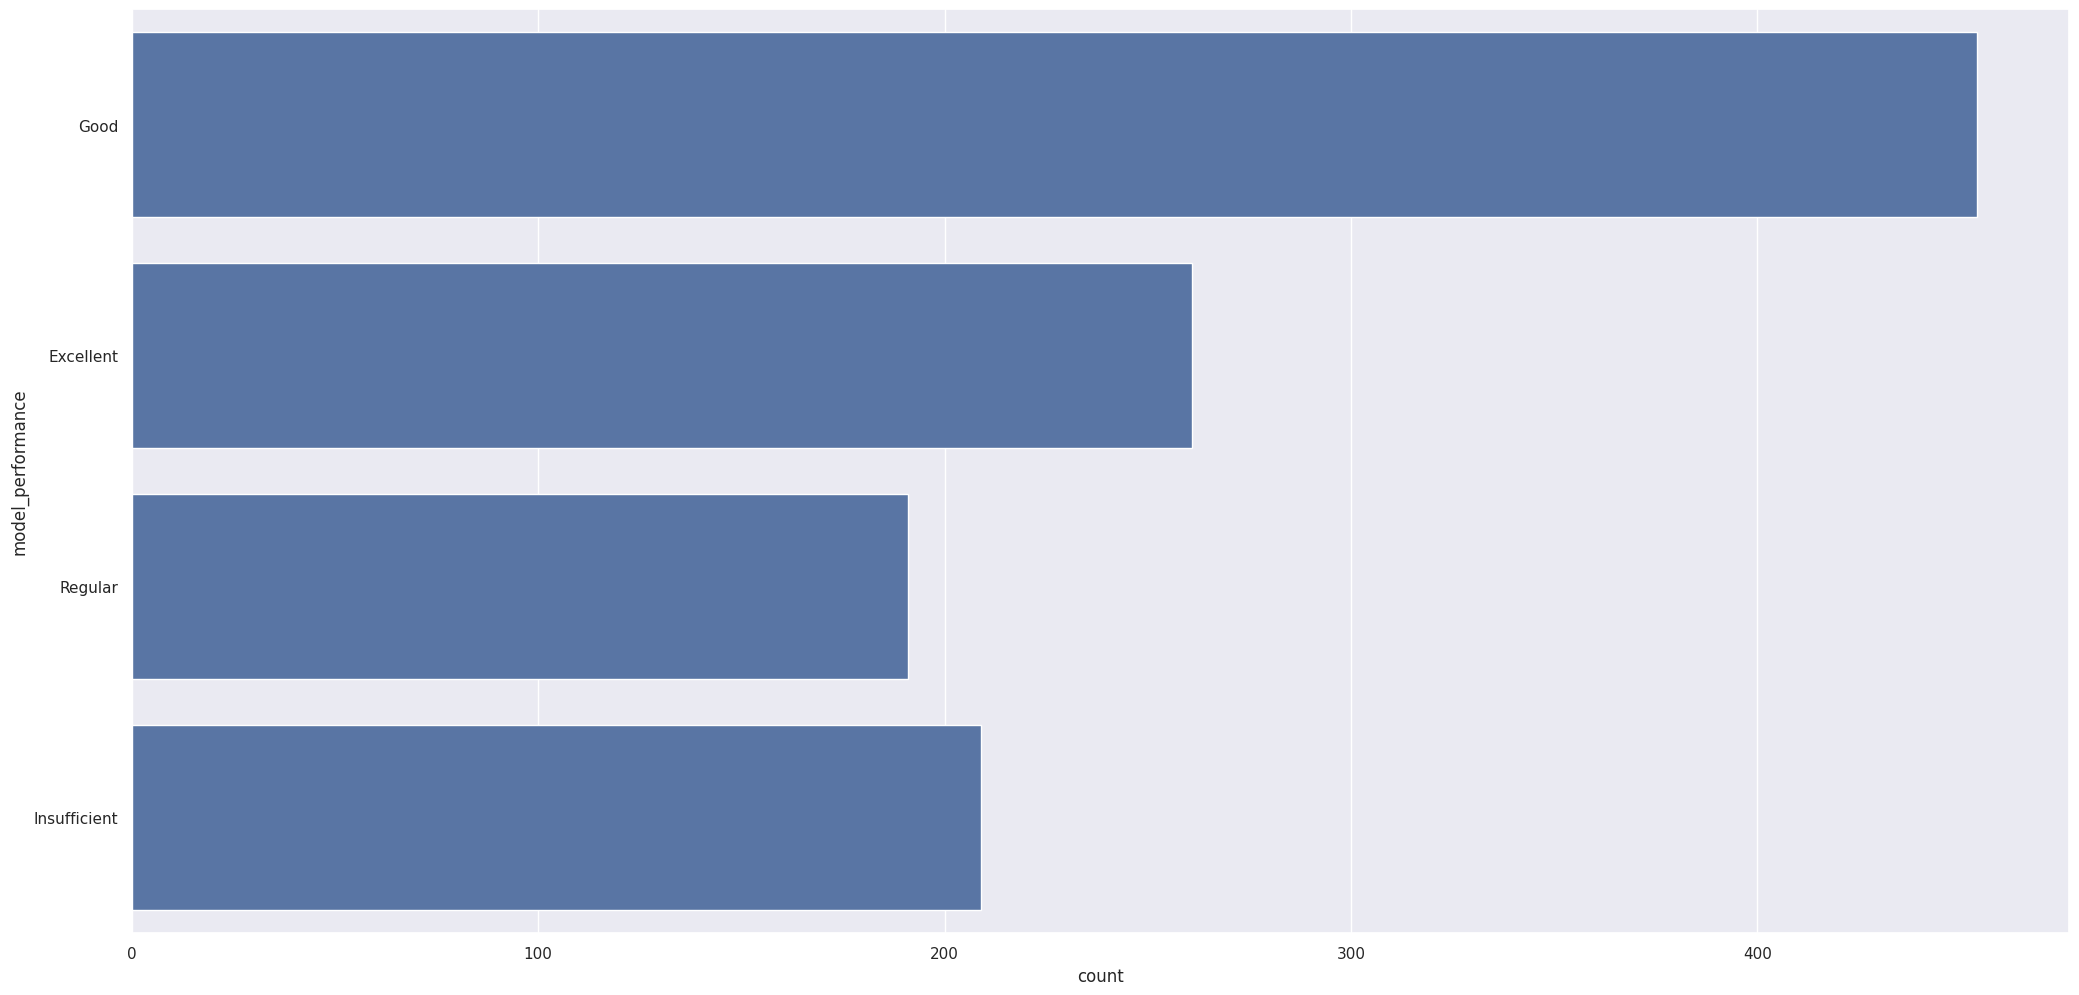

In [132]:
aux = df_performance[ (df_performance['store']!=0 ) ]

sns.countplot( data=aux['model_performance'] );

In [135]:
df_performance['accuracy'].value_counts()
#sns.countplot( data=aux['accuracy'] );

accuracy
1    1115
Name: count, dtype: int64

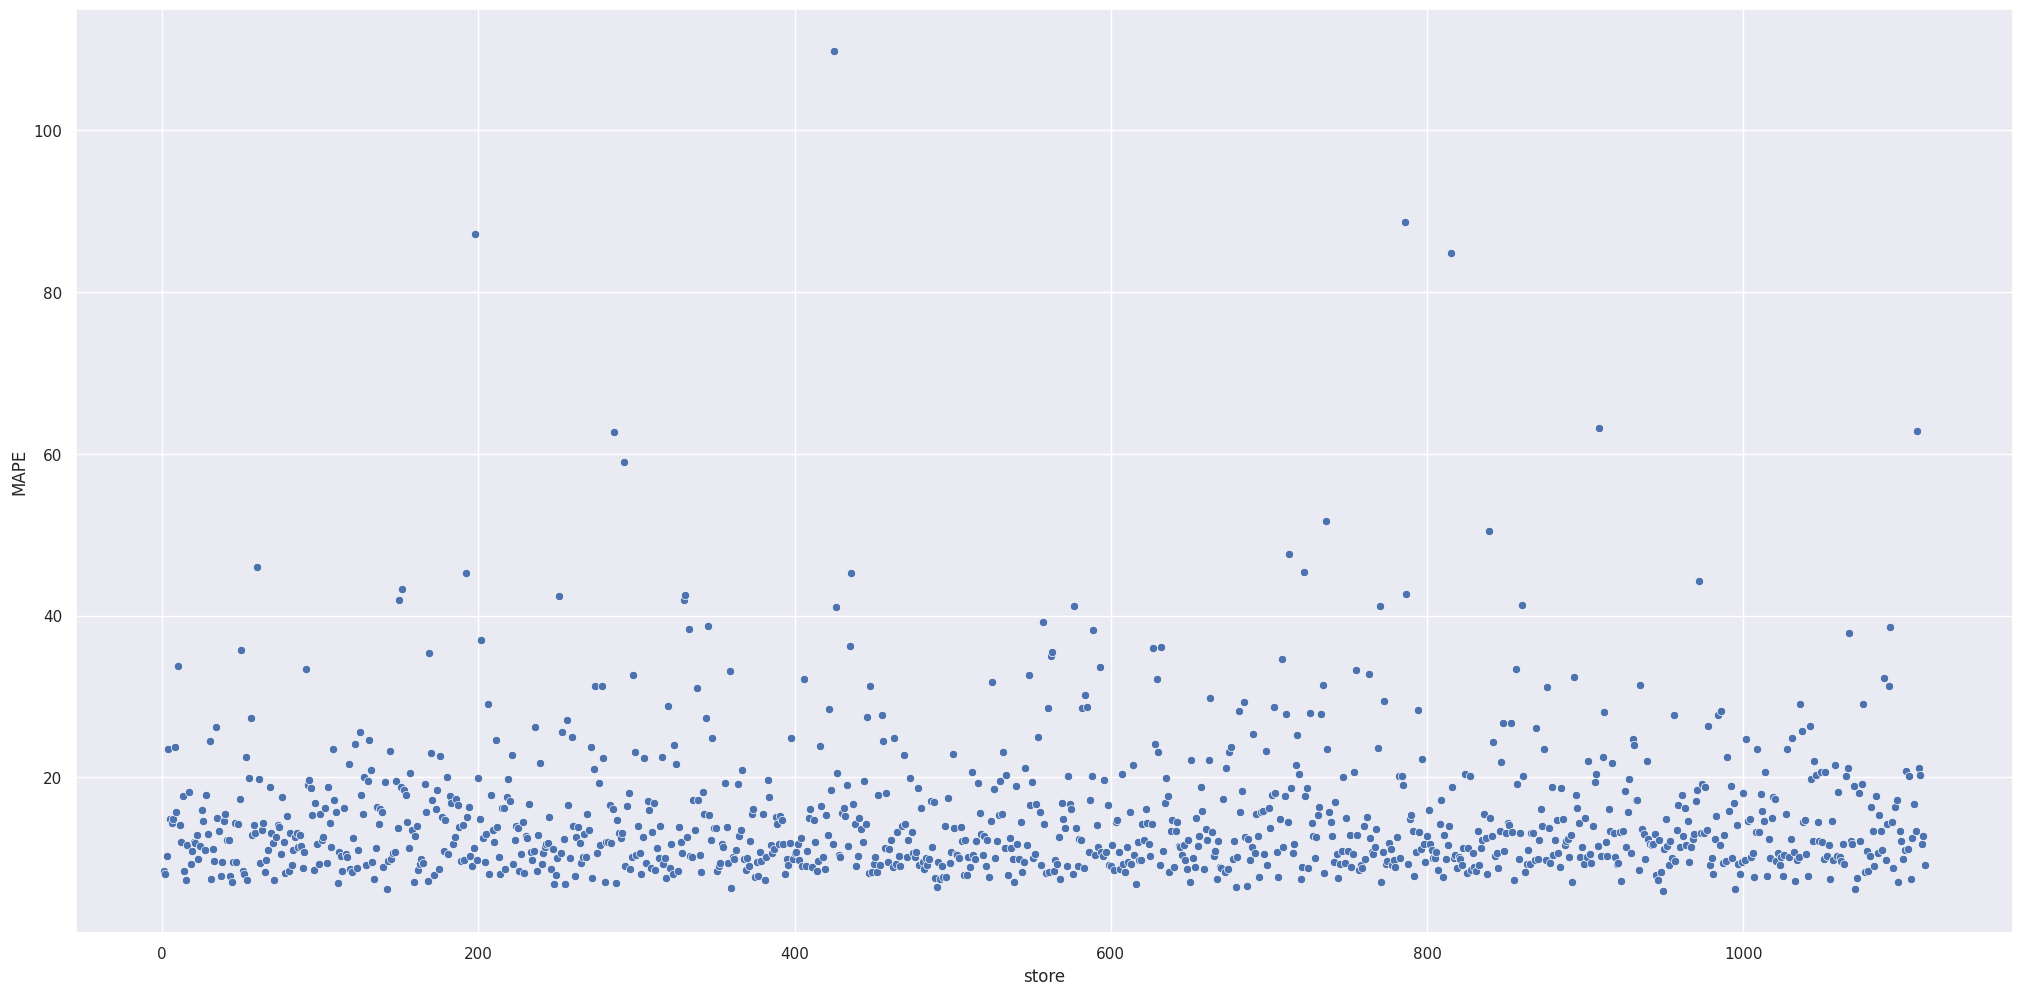

In [26]:
sns.scatterplot( x='store', y='MAPE', data=df_performance);

## 3.2 Total Performance

In [27]:
df3_total_performance = ( df3_preds_metrs[['sales_predictions', 'worst_scenario', 'best_scenario']]
                            .apply( lambda x: np.sum(x), axis=0 )
                            .reset_index()
                            .rename( columns = {'index' : 'Scenario', 0 : 'Values' } ) 
                        )
df3_total_performance['Values'] = df3_total_performance['Values'].map( 'R$ {:,.2f}'.format )
df3_total_performance

,Scenario,Values
0,sales_predictions,"R$ 269,624,160.00"
1,worst_scenario,"R$ 268,445,821.42"
2,best_scenario,"R$ 270,802,522.94"


## 3.3 Machine Learning Performance

In [28]:
df3['error'] = df3['sales'] - df3['sales_predictions']
df3['error_rate'] = df3['sales_predictions'] / df3['sales']

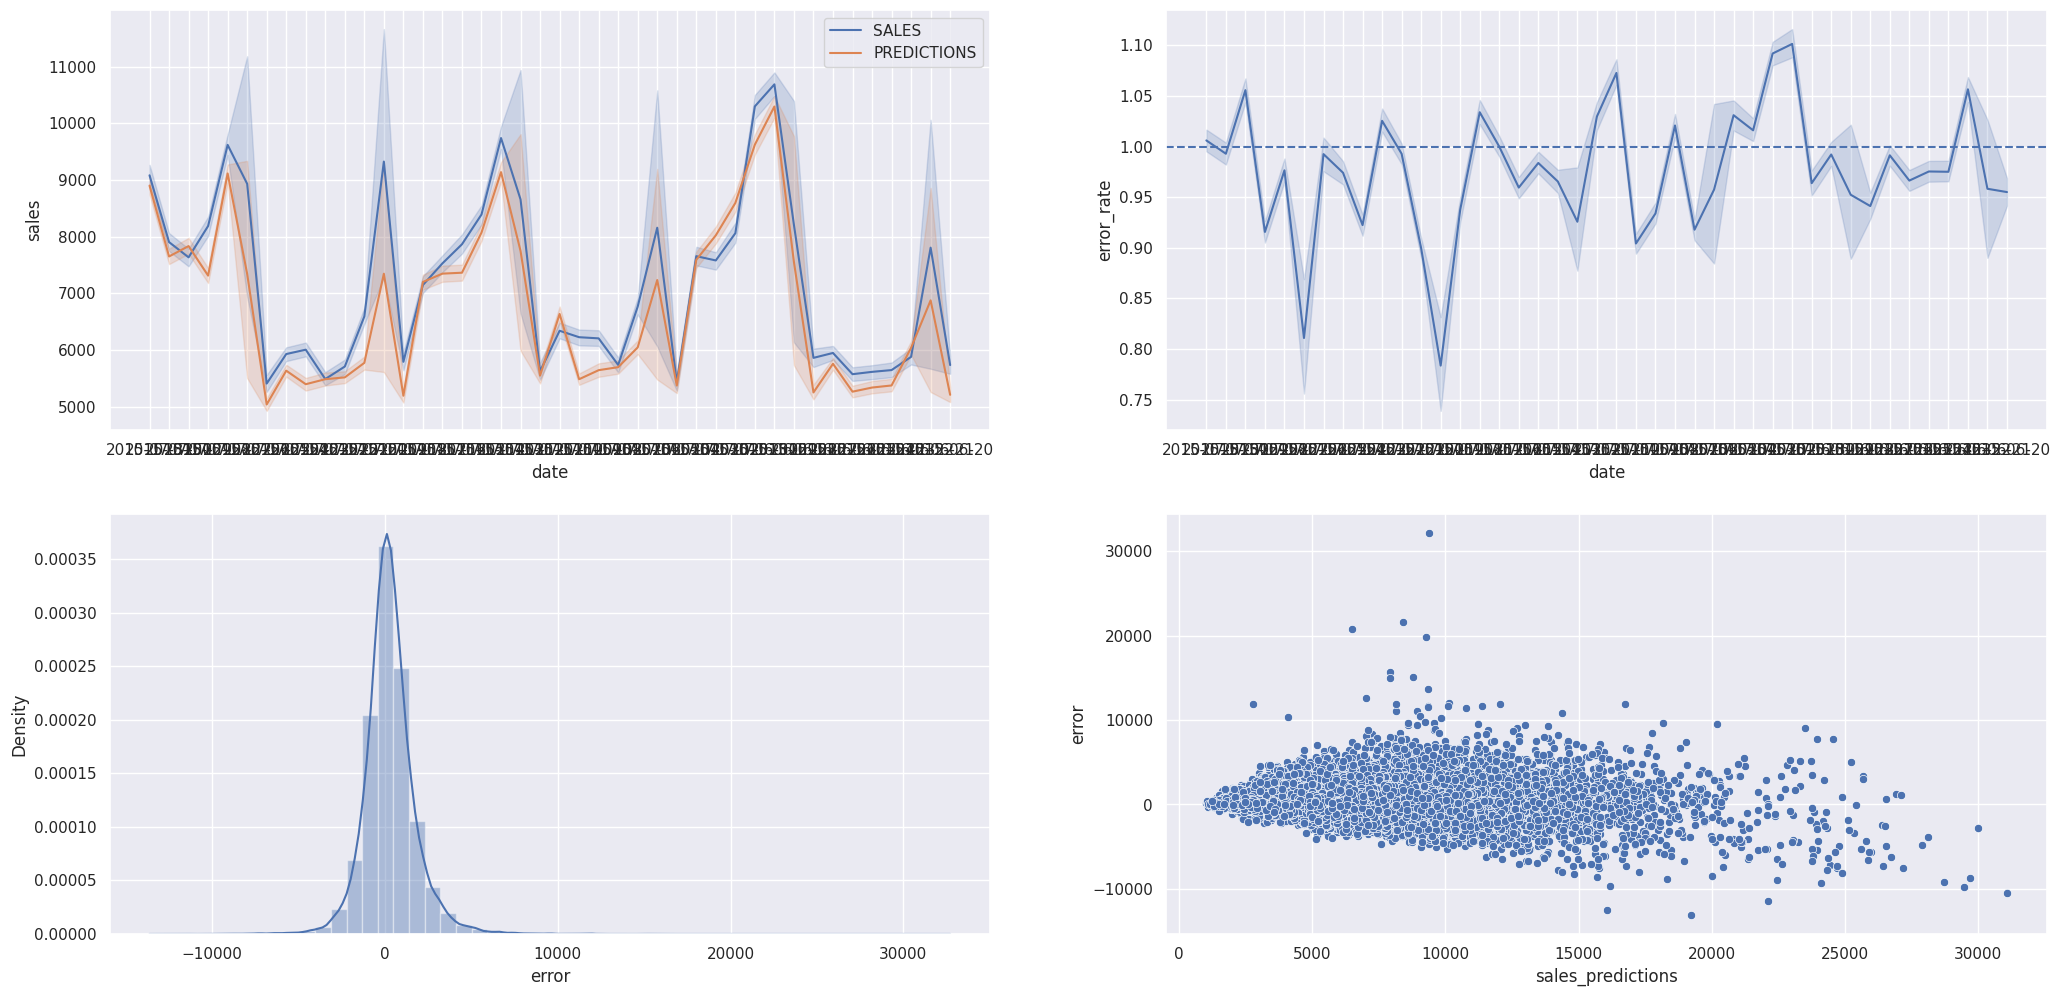

In [29]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df3, label='SALES' );
sns.lineplot( x='date', y='sales_predictions', data=df3, label='PREDICTIONS' );
             
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df3 );
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df3['error'] );

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='sales_predictions', y='error', data=df3 );

# 4.0 Deploy Model to Production

In [30]:
# save Trained Model
pickle.dump( xgb_model_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

## 4.1 CALL API with Production DataSet

In [41]:
# load datasets: prod + store
df_prod_raw  = pd.read_csv( '../data/prod.csv' )
df_store_raw = pd.read_csv( '../data/store.csv' )

# merging datasets: prod + store
df_prod = pd.merge( df_prod_raw, df_store_raw, how='left', on='Store' )
df_prod = df_prod.drop( "Id", axis=1 )
df_prod.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [42]:
# choose store for prediction
df_test = df_prod[  df_prod['Store'].isin( [20, 22] ) ]

# remove close day
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]

df_test['Store'].unique()


array([20, 22])

In [43]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 20, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek

In [46]:
# API CALL

# local request
#url = 'http://0.0.0.0:5000/rossmann/predict'

# Render´s Server request
url = 'https://rossmann-app-9l04.onrender.com/rossmann/predict'

header = { 'Content-type' : 'application/json' }


response = requests.post( url, data=data, headers=header )
print(f'Status Code: { response.status_code } ' )

Status Code: 200 


In [48]:
# return dataframe with predictions
d1 = pd.DataFrame( response.json(), columns=response.json()[0].keys() )
d2 = d1[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
d2.head()

,store,predictions
0,20,193118.194092
1,22,256766.864502


In [132]:
d2[['store', 'predictions']].sort_values( 'predictions', ascending=False).head(10)

,store,predictions
433,562,896213.859375
854,1114,622325.498047
567,733,605381.561523
293,383,597450.305664
279,362,523712.384766
634,822,519882.031250
345,449,500459.166016
292,380,498118.424805
455,587,490592.631836
734,947,464979.828613


In [40]:
d2.head()

,store,predictions
0,20,193118.194092
1,22,256766.864502
